In [ ]:
!pip install '/content/drive/MyDrive/Colab Notebooks/MNIST-PyTorch/shap-master.zip'

In [7]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageOps, ImageEnhance, ImageFilter

import shap

In [55]:
batch_size = 128
num_epochs = 3
device = torch.device('cuda')

In [62]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x
    
    def predict(self, test_images):
        self.eval()
        
        count = test_images.shape[0]
        result_np = []
            
        for idx in range(0, count):
            # print(idx)
            img = test_images[idx, :, :, :]
            img = np.expand_dims(img, axis=0)
            img = torch.Tensor(img).permute(0, 3, 1, 2).to(device)
            # print(img.shape)
            pred = self(img)
            pred_np = pred.cuda().detach().numpy()
            for elem in pred_np:
                result_np.append(elem)
        return result_np

In [52]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           (100. * batch_idx) / len(train_loader),
                                                                           loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()
            pred = output.max(1, keepdim=True)[1]                   # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss,
                                                                                 correct,
                                                                                 len(test_loader.dataset),
                                                                                 (100. * correct) / len(test_loader.dataset)))

In [53]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('/content/drive/MyDrive/Colab Notebooks/MNIST-PyTorch/',
                                                          train = True,
                                                          download = True,
                                                          transform = transforms.Compose([transforms.ToTensor()])),
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('/content/drive/MyDrive/Colab Notebooks/MNIST-PyTorch/',
                                                         train = False,
                                                         transform = transforms.Compose([transforms.ToTensor()])),
                                          batch_size = batch_size,
                                          shuffle = True)

In [63]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),
                      lr = 0.01,
                      momentum = 0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298996
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.248938
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.667761
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.016420
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.029300

Test set: Average loss: 0.0050, Accuracy: 8919/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.774964
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.410255
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.738856
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.611446
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.456445

Test set: Average loss: 0.0027, Accuracy: 9373/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.394468
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.353910
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.536688
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.261848
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.433164

Test set: Average loss: 0.0018, Accuracy: 9507/10000 (95%)



In [64]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/MNIST-PyTorch/model.pth')

In [65]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/MNIST-PyTorch/model.pth'))

<All keys matched successfully>

In [15]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/drive/MyDrive/Colab Notebooks/MNIST-PyTorch/capture.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [72]:
def imgLoader(threshold, img_dir):
    raw_img = Image.open(img_dir)
    # plt.imshow(raw_img)
    # plt.show()

    # Load image as grayscale
    inp_img = Image.open(img_dir).convert('L')
    # Resize to 28*28px
    inp_img = ImageOps.fit(inp_img, (28, 28), method = 0, bleed = 0.0, centering = (0.5, 0.5))
    inp_img = ImageOps.invert(inp_img)

    inp_img = np.asarray(inp_img)

    # Turn gray-ish pixels to white
    inp_img = np.where(inp_img < threshold, 0, inp_img)
    # Darken black-ish pixels
    inp_img = (inp_img / 1000) * 9

    inp_img = np.expand_dims(inp_img, -1)
    inp_img = transforms.functional.to_tensor(inp_img).to(torch.float)

    # plt.imshow(inp_img.reshape(28, 28), cmap = 'Greys')
    # plt.show()
    
    return inp_img

def loadUserImg(targets = ['0', '1', '2'],
                threshold = [190, 190, 190],
                img_dir = '/content/drive/MyDrive/Colab Notebooks/MNIST-PyTorch/Samples/'):
    layers = []

    for i in range(len(targets)):
        layers.append(imgLoader(threshold[i], img_dir + targets[i] + '.jpg'))


    # Convert to tensor
    
    res = torch.stack(layers)

    return res

def predictInput(inpTensor):
    # Take a random set of test images for referencing
    batch = next(iter(test_loader))
    images, _ = batch
    background = images[:100]

    # Init. DeepExplainer
    e = shap.DeepExplainer(model.cpu(), background)
    shap_values = e.shap_values(inpTensor)

    # Plot out DE's result
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(inpTensor.numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


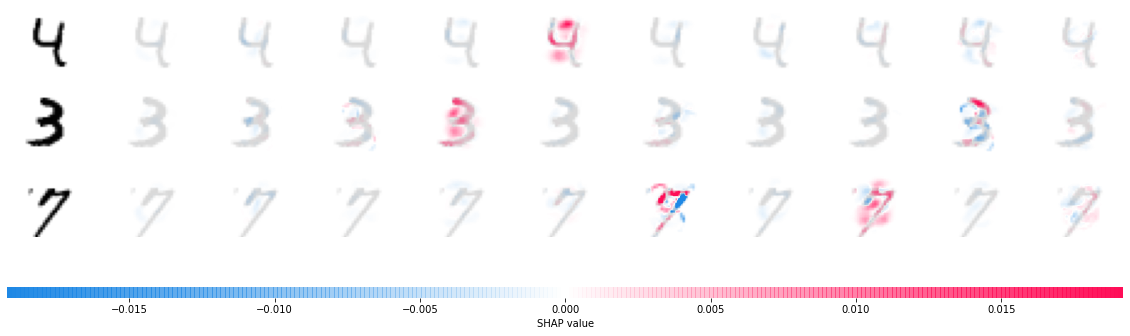

In [76]:
# Test using validation dataset
batch = next(iter(test_loader))
images, _ = batch
predictInput(images[100:103])

In [38]:
take_photo()

<IPython.core.display.Javascript object>

'/content/drive/MyDrive/Colab Notebooks/MNIST-Pytorch/capture.jpg'

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


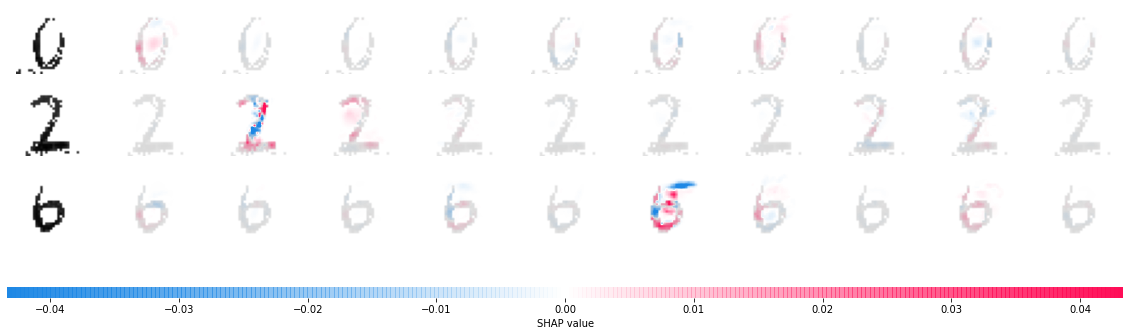

In [93]:
targets     = ['0', '2', '6']
threshold   = [190, 180, 180]

img = loadUserImg(targets, threshold)

predictInput(img)